# Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
def calculate_migration_timestep(D_P, c_t, P_density, K_PF, t_step, V_P, V_F, d_P, d_F, A_PF):
    alpha = (1 / K_PF) * (V_F / V_P)
    d_P = V_P / A_PF        # Annahme, dass das so gilt und das wir einfach nen Zylinder haben 
    upper_alpha = 10

    def calculate_q_n(n, alpha):
        if alpha < 0.1:
            return n * np.pi / (1 + alpha)
        elif alpha > upper_alpha:
            return (2 * n - 1) * np.pi / 2
        else:
            return (n - (alpha / (2 * (1 + alpha)))) * np.pi

    sum_a = 0
    k = 1
    while True:
        q_n = calculate_q_n(k, alpha)
        if alpha > upper_alpha:
            sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        else:
            sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)

        sum_before = sum_a
        sum_a += sum_term_i

        # Terminierung der unendlichen Summe
        if abs(sum_a - sum_before) < 1e-6:
            break
        k += 1

    # Berechnet Migrationsmenge zu dem Zeitpunkt t_step und Fallunterscheidung abhängig von alpha
    if alpha > upper_alpha:
        migration_amount = c_t * P_density * d_P * (1 - sum_a)
    else:
        migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)

    # Verhindert negative Konzentrationen
    if migration_amount < 0:
        migration_amount = 0

    return migration_amount

def migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_known):

    D_P = D_P_known

    migration_data = []
    current_time = 0

    while current_time < t_max:
        migration_amount = calculate_migration_timestep(D_P, c_P0, P_density, K_PF, current_time, V_P, V_F, d_P, d_F, A_PF)
        migration_data.append(migration_amount)
        current_time += dt
        
    migration_data = np.array(migration_data) / 10 # Umrechnung in [mg/dm²]

    return migration_data

def plot_results_area(results, t_max, dt, save_path=None): 
    # Plot the area-specific migration results
    plt.figure(figsize=(10, 6))
    time_days = np.arange(0, t_max / (3600 * 24), dt / (3600 * 24))
    plt.plot(time_days, results, linewidth = 2, color = '#F06D1D')
    
    # Plot speichern, wenn ein Pfad angegeben wurde
    if save_path:
        plot_filename = os.path.join(save_path, 'migrated_mass_plot.pdf')
        plt.savefig(plot_filename, bbox_inches='tight')
        print(f"Migrationsplot gespeichert unter: {plot_filename}")
              
    # Achsenbeschriftungen und Titel
    plt.xlabel('Zeit $[Tage]$', fontsize=14)
    plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def error_function(D_P_candidate, c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, measured_values, measurement_days):
    simulation_result = migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_candidate)
    
    # Indizes: Messzeit in Tagen - 1 (z. B. Tag 7 -> Index 6)
    indices = [day - 1 for day in measurement_days]
    
    sim_values = simulation_result[indices]
    
    error = np.sum((sim_values - measured_values)**2)
    return error


# Physikalisch-chemische Eigenschaften
# M_r = 136            # relative Molekülmasse des Migranten [g/mol]
# T_C = 20             # Temperatur [°C]
# Material = "PP"   # Material des Polymers [-]

c_P0 = 900           # Anfangskonzentration im Polymer [mg/kg]
P_density = 0.9045   # Dichte des Polymers [g/cm^3]
F_density = 0.9      # Dichte des Fluids [g/cm^3]
K_PF = 1             # Verteilungskoeffizient [-]
dt = 86400           # 1 Tag in Sekunden
t_max = 28 * dt      # 28 Tage in Sekunden

# Geometrische Größen
d_P = None            # Durchmesser des Polymers [cm]
d_F = None            # Durchmesser des Fluids [cm]
A_PF = 0.2827             # Kontaktfläche Polymer/Fluid [dm^2] (nach Norm)
V_P = 10.6384    # Volumen des Polymers [cm^3] (von Andre)
V_F = 28.27    # Volumen des Fluids [cm^3] (von Andre)

D_P_var = 1e-8      # Exemplarischer Diffusionskoeffizient in [cm^2/s]
# Umrechnung von Einheiten
m_F = V_F * F_density * 1e-3  # Masse der Kontaktphase in [kg]

# Definieren Sie den Suchbereich in logarithmischem Maßstab:
D_P_candidates = np.logspace(-15, -10, num=100)  # 100 Kandidatenwerte

measurement_days = np.array([7, 14, 28])    # Zeitpunkte der Messungen aus Migrationsversuchen in Tagen
measured_values = (np.array([6.4, 10.2, 12.2]) / A_PF) * m_F # Messwerte der Konzentration (Amberon 60°C) in Kontaktphase in [mg/dm^2]

errors = []
for D_P_candidate in D_P_candidates:
    err = error_function(D_P_candidate, c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, measured_values, measurement_days)
    errors.append(err)

errors = np.array(errors)
optimal_index = np.argmin(errors)
optimal_D_P = D_P_candidates[optimal_index]
print("Optimierter Diffusionskoeffizient:", optimal_D_P, "cm²/s")


Optimierter Diffusionskoeffizient: 1e-15 cm²/s


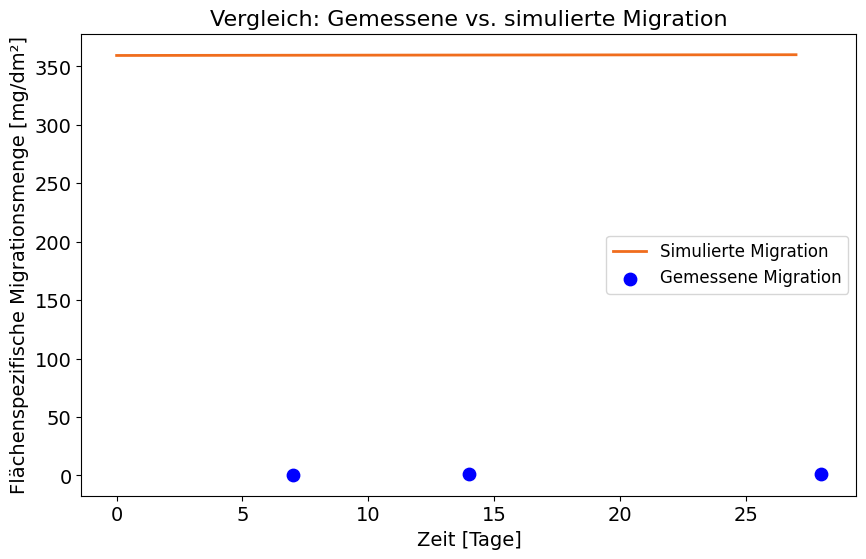

In [10]:
# Simulation mit dem optimierten Diffusionskoeffizienten
optimal_simulation = migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, 1e-10)

# Zeitachse in Tagen (da dt = 1 Tag in Sekunden)
time_days_full = np.arange(0, t_max / 86400, 1)  # 0, 1, 2, ..., 27

# Plot der gesamten berechneten Kurve
plt.figure(figsize=(10, 6))
plt.plot(time_days_full, optimal_simulation, label='Simulierte Migration', linewidth=2, color='#F06D1D')

# Overlay der Messwerte
plt.scatter(measurement_days, measured_values, label='Gemessene Migration', color='blue', s=80, zorder=5)

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit [Tage]', fontsize=14)
plt.ylabel('Flächenspezifische Migrationsmenge [mg/dm²]', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Vergleich: Gemessene vs. simulierte Migration", fontsize=16)
plt.show()

